In [26]:
include("long-experiment.jl")
using Plots
import StatsBase
import LsqFit
import GLM
gr()

  Activating project at `~/Uni/phd/code/form-ismir23/gurobi-experiment`


Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-29


Plots.GRBackend()

### Compare Optimum and Monte Carlo

geometric mean of mc/opt: 1.0855339156193036


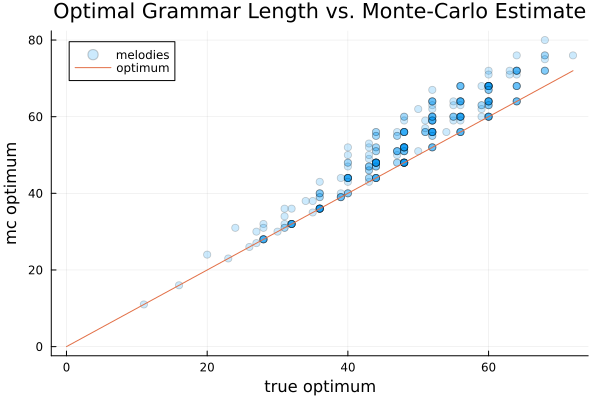

In [42]:
function plot_opt_vs_mc()
    df = compare_grammars()
    println("geometric mean of mc/opt: ", StatsBase.geomean(df.mc ./ df.opt))
    p = scatter(df.opt, df.mc,
            ma=0.2,
            title="Optimal Grammar Length vs. Monte-Carlo Estimate",
            xlabel="true optimum",
            ylabel="mc optimum",
            label="melodies")
    largest = maximum(df.opt)
    plot!(p, [0,largest], [0,largest], label="optimum")
    savefig(p, "../plots/optimal_vs_mc.pdf")
    p
end

plot_opt_vs_mc()

### Runtime

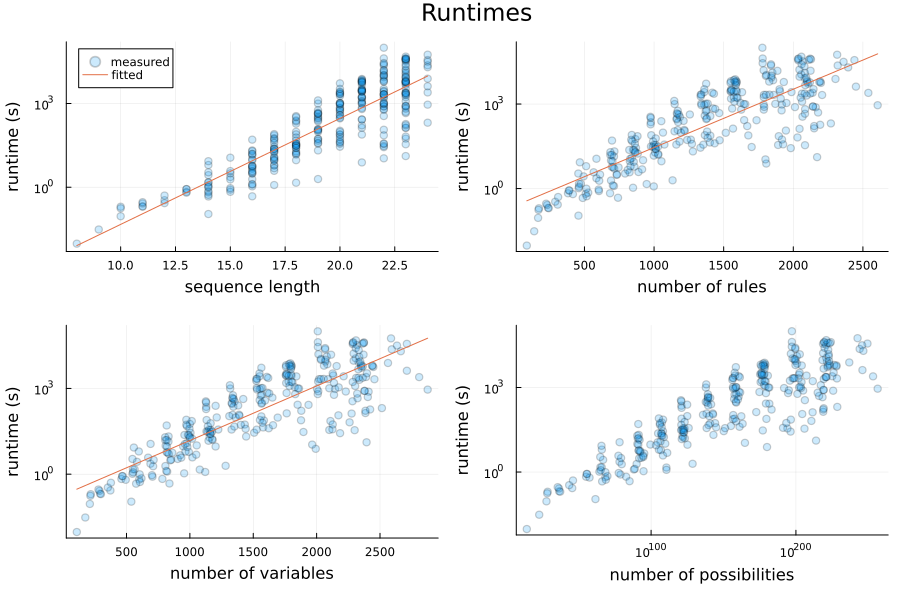

In [32]:
function plot_runtimes()
    names = list_pieces("../data/melodies")
    grammars = [load_minimal_ruleset("../data/melodies/grammars/grammar_$(name).json") for name in names]
    rulesets = [load_ruleset("../data/melodies/rulesets/ruleset_$(name).json") for name in names]
    
    runtimes = [g.runtime for g in grammars]
    ns_rules = [length(r.rules) for r in rulesets]
    ns_notes = [length(g.seq) for g in grammars]
    ns_vars = [length(r.rules) + length(r.symbols) for r in rulesets]
    ns_opts = [prod(BigInt(1) .+ length.(values(r.rule_groups))) for r in rulesets]
    
    @. model(x, p) = p[1]*x - p[2]
    fit_notes = LsqFit.curve_fit(model, ns_notes, log.(runtimes), [0.5, 0.5])
    fit_rules = LsqFit.curve_fit(model, ns_rules, log.(runtimes), [0.5, 0.5])
    fit_vars = LsqFit.curve_fit(model, ns_vars, log.(runtimes), [0.5, 0.5])
    #fit_opts = GLM.lm(GLM.@formula(y ~ x + 1), DataFrame(x=ns_opts, y=runtimes))
        
    p_notes = scatter(ns_notes, runtimes,
                      label="measured", xlabel="sequence length",
                      legend_position=:topleft, yscale=:log10)
    p_rules = scatter(ns_rules, runtimes,
                      label="measured", xlabel="number of rules",
                      legend=false, yscale=:log10)
    p_vars = scatter(ns_vars, runtimes,
                     label="measured", xlabel="number of variables",
                     legend=false, yscale=:log10)
    p_opts = scatter(ns_opts, runtimes,
                     label="measured", xlabel="number of possibilities",
                     legend=false, yscale=:log10, xscale=:log10)
    
    x_notes = sort(ns_notes)
    y_notes = exp.(model(x_notes, fit_notes.param))
    
    x_rules = sort(ns_rules)
    y_rules = exp.(model(x_rules, fit_rules.param))
    
    x_vars = sort(ns_vars)
    y_vars = exp.(model(x_vars, fit_vars.param))
    
#     x_opts = sort(ns_opts)
#     y_opts = GLM.predict(fit_opts, x_opts)
    
    plot!(p_notes, x_notes, y_notes, label="fitted")
    plot!(p_rules, x_rules, y_rules, label="fitted")
    plot!(p_vars, x_vars, y_vars, label="fitted")
#     plot!(p_opts, x_opts, y_opts, label="fitted")
    
    savefig(p_notes, "../plots/rt_vs_notes.pdf")
    savefig(p_rules, "../plots/rt_vs_rules.pdf")
    savefig(p_vars, "../plots/rt_vs_vars.pdf")
    savefig(p_opts, "../plots/rt_vs_opts.pdf")
        
    plot(p_notes, p_rules, p_vars, p_opts,
         ma=0.2,
         ylabel="runtime (s)",
         #yscale=:log10, #yticks=[0.1,1,10,100,1000,10000,100000],
         layout=(2,2), size=(900,600),
         bottom_margin=5Plots.mm, left_margin=3Plots.mm,
         plot_title="Runtimes")
end

plot_runtimes()

### Compression

average compression ratio: 2.4632030325228174


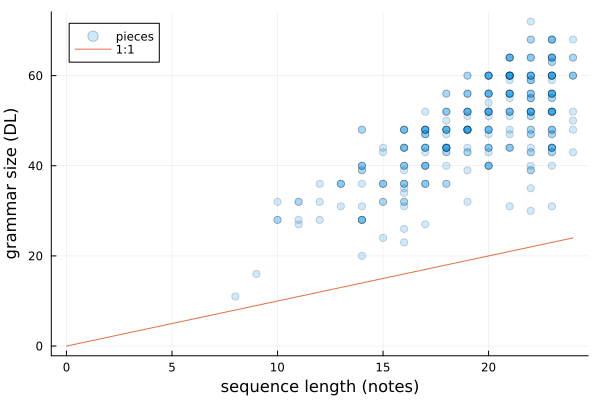

In [43]:
function plot_compression(cost_fn=rule_dl_cost_humphreyslike)
    names = list_pieces("../data/melodies")
    grammars = [load_minimal_ruleset("../data/melodies/grammars/grammar_$(name).json") for name in names]
    
    lens = [length(g.seq) for g in grammars]
    dls = [sum(cost_fn.(g.rules)) for g in grammars]
    println("average compression ratio: ", StatsBase.geomean(dls ./ lens))
    
    p = scatter(lens, dls, ma=0.2, label="pieces", xlabel="sequence length (notes)", ylabel="grammar size (DL)")
    largest = min(maximum(lens), maximum(dls))
    plot!(p, [0,largest], [0,largest], label="1:1")
    savefig(p, "../plots/compression.pdf")
    p
end

plot_compression()

### Example Minimal Grammar

In [5]:
min_grammar_example2 = load_minimal_ruleset("../data/grammar_example2.json")
print(indent_lines(grammar_tex(min_grammar_example2), 4))

    \begin{tabular}{llll}
    \toprule
    rule & & meta rule & cost\\
    \midrule
    $r_{1}$ & $ S_{198} \longrightarrow S_{277}\ S_{398} $ & $ \alpha\beta\beta\alpha(S_{277}, S_{398}) $ & 4 \\
    $r_{2}$ & $ S_{277} \longrightarrow S_{98}\ S_{164} $ & $ \alpha\beta(S_{98}, S_{164}) $ & 4 \\
    $r_{3}$ & $ S_{398} \longrightarrow S_{347}\ g2 $ & $ \alpha\beta(S_{347}, g2) $ & 4 \\
    $r_{4}$ & $ S_{98} \longrightarrow S_{173}\ S_{18} $ & $ \alpha\alpha\beta(S_{173}, S_{18}) $ & 4 \\
    $r_{5}$ & $ S_{164} \longrightarrow g4\ e1 $ & $ \alpha\beta(g4, e1) $ & 4 \\
    $r_{6}$ & $ S_{347} \longrightarrow d4\ S_{136} $ & $ \alpha\alpha\beta(d4, S_{136}) $ & 4 \\
    $r_{7}$ & $ S_{173} \longrightarrow g2\ e2 $ & $ \alpha\beta(g2, e2) $ & 4 \\
    $r_{8}$ & $ S_{18} \longrightarrow f4\ e4 $ & $ \alpha\beta\alpha(f4, e4) $ & 4 \\
    $r_{9}$ & $ S_{136} \longrightarrow f4\ e4 $ & $ \alpha\alpha\beta\alpha(f4, e4) $ & 4 \\
    \bottomrule
    \end{tabular}
    

In [7]:
print(indent_lines(grammar_qtree(min_grammar_example2), 4))

    \Tree [.$S_{198}$
      [.$S_{277}$
        [.$S_{98}$
          [.$S_{173}$ g2 e2 ]
          [.$S_{173}$ g2 e2 ]
          [.$S_{18}$ f4 e4 f4 ]
        ]
        [.$S_{164}$ g4 e1 ]
      ]
      [.$S_{398}$
        [.$S_{347}$
          d4
          d4
          [.$S_{136}$ f4 f4 e4 f4 ]
        ]
        g2
      ]
      [.$S_{398}$
        [.$S_{347}$
          d4
          d4
          [.$S_{136}$ f4 f4 e4 f4 ]
        ]
        g2
      ]
      [.$S_{277}$
        [.$S_{98}$
          [.$S_{173}$ g2 e2 ]
          [.$S_{173}$ g2 e2 ]
          [.$S_{18}$ f4 e4 f4 ]
        ]
        [.$S_{164}$ g4 e1 ]
      ]
    ]